# The following Data analysis explores Patent infringment cases in the US from the U.S. Patient Website 

1. How long does the average patent case take to be settled?
2. What are the top 20 Courthouses that entertain patent law?
3. What are the top 20 most frequent settlment disputes?
4. What is the frequency of patent cases year over year?
5. Who are the top 20 patent trolls?
6. Who are the top 20 respondents of patent trolls?
7. Who are the top 20 judges that preside over most patent-law cases?
8. How often are juries requested and by whom?
9. Can a machine learning model be developed to forecast the cost of patent cases in the next 10 years?
10. Where do patent trolls get all their patents?


In [1]:
#-- Importing the Nessesary Libraries --#
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor

# Data Import and Cleaning

In [2]:
#-- Importing the raw dataset --#
df_raw = pd.read_csv('/Users/michaelsegaline/Desktop/Research Objectives/Patient scandal/patent_cases.csv')

In [3]:
#-- Inspecting the column headings --#
df_raw.head()

,case_row_id,case_number,case_number_raw,district_id,court_name,pacer_id,case_name,assigned_to,referred_to,case_cause,...,date_last_filed,jury_demand,demand,lead_case,related_case,settlement,case_type_1,case_type_2,case_type_3,case_type_note
0,78028.0,4:92-cv-00055,4:92-cv-00055-JWS,akd,Alaska District Court,5408.0,"Melba Creek Mining, Inc. et al v. Sykes et al",Judge John W Sedwick,NaN,No cause code entered,...,12/22/92,Defendant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,75332.0,2:10-cv-00601,2:10-cv-00601-WKW-TFM,almd,Middle District of Alabama,43636.0,Bowhall v. Johnson & Johnson Inc. et al (MAG+),Honorable William Keith Watkins,Honorable Terry F. Moorer,15:1126 Patent Infringement,...,3/16/11,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6908.0,1:98-cv-00596,1:98-cv-00596-RBP,alnd,Northern District of Alabama,5576.0,Mettke v. Touchnet Information,Judge Robert B Propst,NaN,35:183 Patent Infringement,...,10/1/98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6933.0,1:98-cv-00654,1:98-cv-00654-CB-C,alsd,Southern District of Alabama,27451.0,"Monsanto Co. Inc. v. Styron, et al","Senior Judge Charles R. Butler, Jr",Magistrate Judge William E. Cassady,28:1338 Patent Infringement,...,3/15/99,Defendant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,86730.0,1:18-cv-00012,1:18-cv-00012-BRW,ared,Eastern District of Arkansas,110647.0,Sundesa LLC v. Eurark LLC,Judge Billy Roy Wilson,NaN,35:271 Patent Infringement,...,7/6/18,Both,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [4]:
#-- Inspecting the shape --#
df_raw.shape

(96966, 23)

In [5]:
#-- Inspecting the column names --#
df_raw.columns

Index(['case_row_id', 'case_number', 'case_number_raw', 'district_id',
       'court_name', 'pacer_id', 'case_name', 'assigned_to', 'referred_to',
       'case_cause', 'jurisdictional_basis', 'date_filed', 'date_closed',
       'date_last_filed', 'jury_demand', 'demand', 'lead_case', 'related_case',
       'settlement', 'case_type_1', 'case_type_2', 'case_type_3',
       'case_type_note'],
      dtype='object')

In [6]:
#-- Creating a dataset of only relevant variables to be explored --#

df = df_raw[['court_name', 'case_name', 'assigned_to', 'date_filed', 'date_closed', 'jury_demand']]

In [7]:
df.shape

(96966, 6)

In [8]:
#-- Dropping all rows with missing values --#
df = df.dropna()

In [9]:
#-- Reinspecting the shape --#
df.shape

(87331, 6)

9635 rows dropped. 9635 / 96966 = 0.09 or 9% sparse before all missing rows where dropped. 

Now converting dates

In [10]:
#-- Ensuring 'date_filed' and 'date_closed' are in datetime format, with invalid parsing resulting in NaT --#
df['date_filed'] = pd.to_datetime(df['date_filed'], errors='coerce')
df['date_closed'] = pd.to_datetime(df['date_closed'], errors='coerce')

#-- Create a new column 'case_time' as the difference between 'date_closed' and 'date_filed' --#
df['case_time'] = df['date_closed'] - df['date_filed']

#-- Display the resulting DataFrame with the new column --#
df.head()



,court_name,case_name,assigned_to,date_filed,date_closed,jury_demand,case_time
0,Alaska District Court,"Melba Creek Mining, Inc. et al v. Sykes et al",Judge John W Sedwick,1992-12-22,1993-02-16,Defendant,56 days
1,Middle District of Alabama,Bowhall v. Johnson & Johnson Inc. et al (MAG+),Honorable William Keith Watkins,2010-07-14,2010-10-12,None,90 days
3,Southern District of Alabama,"Monsanto Co. Inc. v. Styron, et al","Senior Judge Charles R. Butler, Jr",1998-06-29,1999-03-15,Defendant,259 days
4,Eastern District of Arkansas,Sundesa LLC v. Eurark LLC,Judge Billy Roy Wilson,2018-02-13,2018-07-06,Both,143 days
5,Western District of Arkansas,Industrial Technology Research Institute v. Sa...,Honorable Harry F. Barnes,2009-10-19,2010-01-19,Plaintiff,92 days


In [11]:
#-- Now seperating jury_demand into independent categories and converting it to binary --#
jury_demand_dummies = pd.get_dummies(df['jury_demand'], prefix='jury_demand')


#-- Dropping the original 'jury_demand' column if it's no longer needed --#
df.drop('jury_demand', axis=1, inplace=True)

# 1. How long does the average patient case take to be settled?

In [12]:
#-- Generating descriptive statistics on case_time --#
df.case_time.describe()

count                          87307
mean     428 days 11:25:51.009655576
std      538 days 08:14:11.863390328
min            -34324 days +00:00:00
25%                121 days 00:00:00
50%                252 days 00:00:00
75%                534 days 00:00:00
max               9027 days 00:00:00
Name: case_time, dtype: object

Now seperating into case_name into two seperate columns: 'petitioner' and 'respondent'.

In [13]:
#-- Splitting the 'case_name' column into 'petitioner' and 'respondent' based on ' v. ' --#
df[['petitioner', 'respondent']] = df['case_name'].str.split(' v. ', n=1, expand=True)

#-- Removing all blank spaces in the new columns --#
df['petitioner'] = df['petitioner'].str.replace(' ', '', regex=True)
df['respondent'] = df['respondent'].str.replace(' ', '', regex=True)

#-- Displaying the resulting DataFrame --#
df[['petitioner', 'respondent']]

,petitioner,respondent
0,"MelbaCreekMining,Inc.etal",Sykesetal
1,Bowhall,Johnson&JohnsonInc.etal(MAG+)
3,MonsantoCo.Inc.,"Styron,etal"
4,SundesaLLC,EurarkLLC
5,IndustrialTechnologyResearchInstitute,"SamsungElectronicsAmerica,Inc.etal"
...,...,...
96961,CheyLand&Cattle,CrownCork&SealCo
96962,WeirMineralsAustraliaLtd,MegatrolIncetal
96963,KimsKreationsInc,WaltDisneyCompany
96964,RetractableTechnologiesLLC,RadioShackCorporationetal


In [14]:
#-- Converting 'filed_date' to datetime--#
df['filed_date'] = pd.to_datetime(df['date_filed'], format='%Y/%m/%d')

#-- Extracting the year and creating a new column --#
df['year_filed'] = df['filed_date'].dt.year

In [ ]:
#-- Saving the cleaned dataset --#
df.to_csv('/Users/michaelsegaline/Desktop/Research Objectives/Patient scandal/cleaned sets cases.csv',index =False)

# Data Exploration 

# 2. What are the top 20 Courthouses that entertain patient law?

In [15]:
#-- Counting the occurrences of each court name --#
court_name_counts = df['court_name'].value_counts()

# Getting the top 20 most frequent court names --#
top_20_court_names = court_name_counts.head(20)

print(top_20_court_names)

Eastern District of Texas           12686
Delaware District Court              9651
Central District of California       7592
Northern District of California      5747
Northern District of Illinois        4384
New Jersey District Court            3566
Southern District of New York        2953
Southern District of Florida         2018
Southern District of California      1940
Massachusetts District Court         1866
Western District of Texas            1845
Northern District of Texas           1646
Eastern District of Virginia         1621
Eastern District of Michigan         1617
Middle District of Florida           1522
Minnesota District Court             1368
Northern District of Georgia         1322
Southern District of Texas           1292
Western District of Washington       1163
Northern District of Ohio            1155
Name: court_name, dtype: int64


# 3. What are the top 20 most frequent settlment disputes?

In [16]:
#-- Counting the occurrences of each court name --#
court_name_counts = df['case_name'].value_counts()

#-- Getting the top 20 most frequent court names --#
top_20_court_names = court_name_counts.head(20)

print(top_20_court_names)

Uniloc USA, Inc. et al v. Apple Inc.                                                              34
Uniloc 2017 LLC  et al v. Google LLC                                                              31
Undefined                                                                                         29
CASE NUMBER NOT USED                                                                              21
Uniloc USA  Inc et al v. LG Electronics U.S.A., Inc. et al                                        15
American Vehicular Sciences LLC v. Toyota Motor Corporation et al                                 14
WSOU Investments LLC v. Huawei Technologies Co., Ltd. et al                                       13
Oakley, Inc. v. The Partnerships and Unincorporated Associations Identified on Schedule "A"       13
Uniloc 2017 LLC v. Microsoft Corporation                                                          13
Uniloc USA, Inc. et al v. Huawei Device USA, Inc. et al                                    

# 4.  What is the frequency of patient cases year over year?

In [81]:
df['values'] = df.groupby('year_filed')['year_filed'].transform('count')

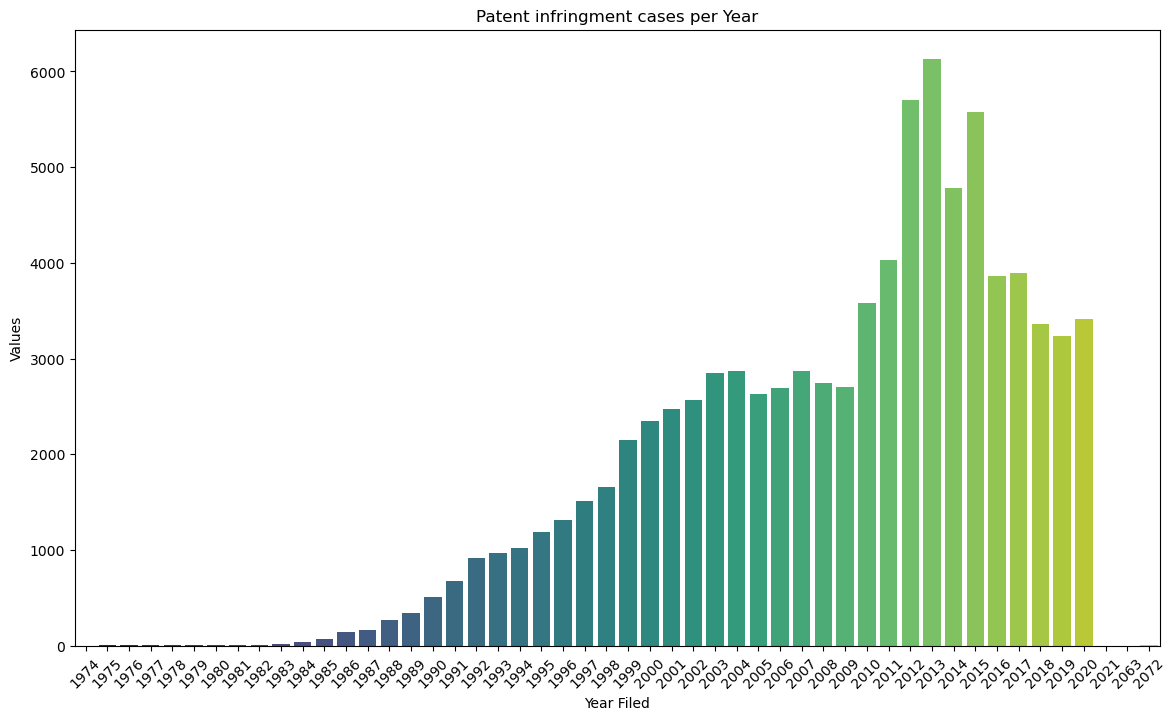

In [86]:
plt.figure(figsize=(14, 8))
sns.barplot(data=df, x='year_filed', y='values', palette='viridis')

# Customize the plot
plt.title('Patent infringment cases per Year')
plt.xlabel('Year Filed')
plt.ylabel('Values')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()

In [18]:
#-- Getting the frequency count of each year --#
year_counts = df['year_filed'].value_counts()

#-- Finding the year with the highest frequency count --#
most_frequent_year = year_counts.idxmax()
most_frequent_count = year_counts.max()

print(f'The year with the most frequency count is {most_frequent_year} with {most_frequent_count} occurrences.')

The year with the most frequency count is 2013 with 6129 occurrences.


# 5. Who are the top 20 patient trolls?

 Now exploring the petitioners via wordcloud.

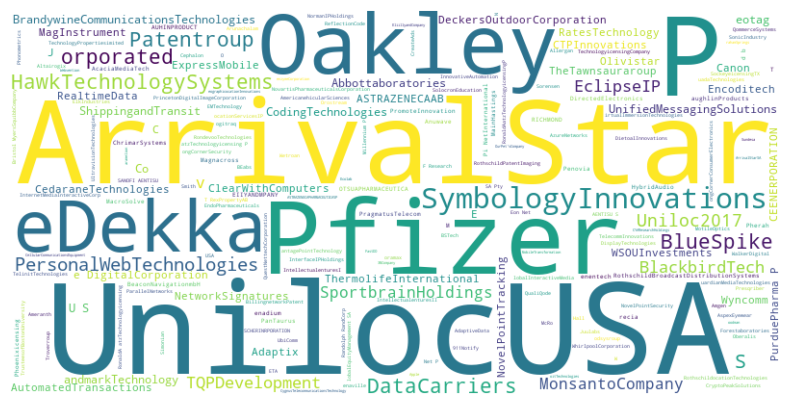

In [75]:
#-- List of words to remove --#
words_2_remove = ['etal', 'INC', 'Inc', 'Inc.', 'LLC', 'llc', 'CO','Co' 'LLCetal', 'L.L.C', 'LTD', 'Ltd', 'LLCetal','K','G','L','V']

#-- Function to clean the petitioner names --#
def clean_text(text):
    for word in words_2_remove:
        text = text.replace(word, '')
    return text.strip()

#-- Applying the cleaning function to the petitioner column --#
df['cleaned_petitioner'] = df['petitioner'].apply(clean_text)

#-- Join all petitioner names into a single string for the word cloud --#
text_for_wordcloud = ' '.join(df['cleaned_petitioner'])

#-- Generating the word cloud --#
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_for_wordcloud)

#-- Displaying the word cloud --#
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [20]:
name_counts = df['cleaned_petitioner'].value_counts()

#-- Getting the top 20 names --#
top_20_names = name_counts.head(20)

print(top_20_names)

UnilocUSA,.                 354
ArrivalStarS.A.             332
eDekka                      250
BlueSpike,                  170
HawkTechnologySystems,      167
MonsantoCompany             157
Uniloc2017                  150
TQPDevelopment,             149
SymbologyInnovations,       145
Patentroup,                 145
SportbrainHoldings          138
EclipseIP                   134
BlackbirdTech               128
ShippingandTransit,         128
Pfizer.                     125
Oakley                      124
PersonalWebTechnologies,    108
EIIYANDMPANY                104
DataCarriers                103
CodingTechnologies,         101
Name: cleaned_petitioner, dtype: int64


# 6. Who are the top 20 respondents of patent trolls?

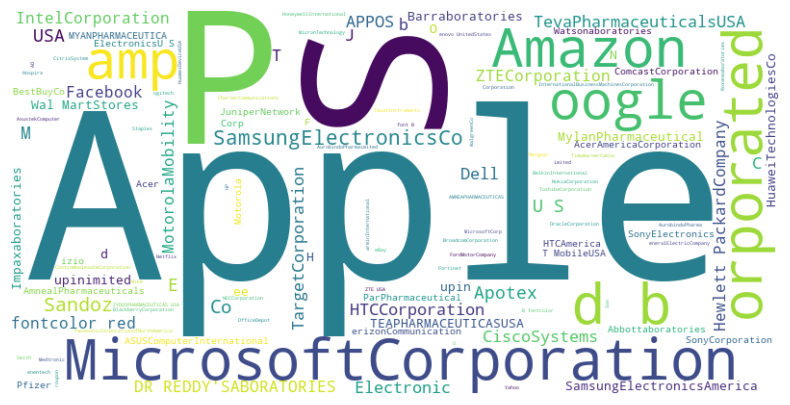

In [87]:
def clean_text(text):
    if text is None:  # Check if the text is None
        return ''  # Return an empty string or any other default value
    for word in words_2_remove:
        text = text.replace(word, '')
    return text.strip()

# Apply the cleaning function to the respondent column
df['cleaned_respondent'] = df['respondent'].apply(clean_text)

# Join all respondent names into a single string for the word cloud
text_for_wordcloud = ' '.join(df['cleaned_respondent'])

#-- Generating the word cloud --#
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_for_wordcloud)

#-- Displaying the word cloud --#
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [92]:
name_counts = df['respondent'].value_counts()

#-- Getting the top 20 names --#
top_20_names = name_counts.head(100)

print(top_20_names)

AppleInc.                         253
MicrosoftCorporation              240
SamsungElectronicsCo.,Ltd.etal    119
Apple,Inc.                        111
GoogleLLC                          95
                                 ... 
3MCompany                          24
NCRCorporation                     24
ValveCorporation                   24
LGElectronicsU.S.A.,Inc.           24
EastmanKodakCompany                24
Name: respondent, Length: 100, dtype: int64


In [93]:
top_20_names.sum()

4633

In [94]:
4633 / 87373

0.053025534203930275

# 7. Who are the top 20 judges that preside over most patent-law cases?


In [22]:
judges = df['assigned_to'].value_counts()

#-- Getting the top 20 names --#
top_20_judges = judges.head(20)

print(top_20_judges)

Judge Rodney Gilstrap             5107
Judge Robert W. Schroeder, III    2028
Judge Leonard P. Stark            1841
Judge Richard G. Andrews          1731
Judge Gregory M. Sleet            1572
Vacant Judgeship (2002)           1275
Judge Leonard Davis               1142
Judge Unassigned Judge            1133
Judge Sue L. Robinson             1082
Judge Alan D Albright              927
Judge T. John Ward                 809
Judge David Folsom                 581
Judge Colm F. Connolly             581
Judge Maryellen Noreika            553
Judge Michael H. Schneider         514
Judge James V. Selna               511
Judge David O. Carter              402
Judge S. James Otero               354
Judge Joseph J. Farnan Jr.         343
Judge Ron Clark                    323
Name: assigned_to, dtype: int64


# 8. How often are juries requested and by whom?

In [23]:
#-- Creating a DataFrame with just the jury_demand dummy variables --#
jury_demand_df = df[['jury_demand_Both', 'jury_demand_Defendant', 'jury_demand_None', 'jury_demand_Plaintiff']]



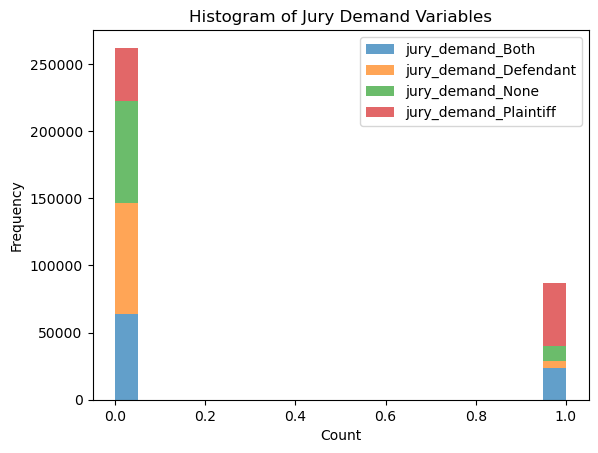

In [24]:
jury_demand_df.plot(kind='hist', alpha=0.7, stacked=True, bins=20)
plt.title('Histogram of Jury Demand Variables')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

# Machine Learning to forecast
Now running random forrest to attempt predictions

In [53]:
#-- Reducing the dataset to 2010 and yearlier because prior to 2010 to remove outliers --#
df_filtered = df[df['year_filed'] <= 2010]


In [54]:
#-- Ensuring the dataset is filtered --#
df_filtered['year_filed'].max()

2010

In [55]:
#-- Inspecting the columns --#
df_filtered.columns

Index(['court_name', 'case_name', 'assigned_to', 'date_filed', 'date_closed',
       'case_time', 'jury_demand_Both', 'jury_demand_Defendant',
       'jury_demand_None', 'jury_demand_P', 'jury_demand_Plaintiff',
       'jury_demand_Unknown', 'jury_demand_Y', 'jury_demand_y', 'petitioner',
       'respondent', 'filed_date', 'year_filed', 'cleaned_petitioner'],
      dtype='object')

In [56]:
#-- Creating a 'values' column as count of occurrences per year --#
df_filtered['values'] = df_filtered.groupby('year_filed')['year_filed'].transform('count')


/var/folders/_5/26fwgmd14qz8pgwfvn4dfky40000gn/T/ipykernel_57058/2334085322.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['values'] = df_filtered.groupby('year_filed')['year_filed'].transform('count')


In [57]:
#-- Spliting the x and y variables in train_test_split() which will output a tuple of 4 varaibles for testing --#

X = df_filtered[['year_filed']]  #-- Features --#
y = df_filtered['values']        #-- Target --#

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [65]:
#-- Defining individual models --#
model1 = RandomForestRegressor(n_estimators=50, random_state=42)
model2 = GradientBoostingRegressor(n_estimators=50, random_state=42)
model3 = LinearRegression()

In [66]:
from sklearn.ensemble import VotingRegressor

#-- Combining the models using VotingRegressor --#
ensemble_model = VotingRegressor(estimators=[
    ('rf', model1), 
    ('gb', model2), 
    ('lr', model3)
])


In [67]:
#-- Fitting the ensemble model --#
ensemble_model.fit(X_train, y_train)

#-- Making predictions on the test set --#
y_pred = ensemble_model.predict(X_test)


In [68]:
#-- Calculate Mean Squared Error (MSE) and R² score --#
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')


Mean Squared Error: 8549.321754617513
R² Score: 0.986855158109569


In [74]:
last_year = df_filtered['year_filed'].max()

#-- Generating the next 20 years starting from the year after the most recent year --#
future_years = pd.DataFrame({'year_filed': np.arange(last_year + 1, last_year + 21)})

#-- Predicting the yearly_count for the next 20 years --#
future_predictions = ensemble_model.predict(future_years)

#-- Printing the forecasted values --#
print("Forecasted yearly_counts for the next 20 years starting at 2011:")
for year, count in zip(future_years['year_filed'], future_predictions):
    print(f"Year: {year}, Predicted Yearly Count: {count}")



Forecasted yearly_counts for the next 20 years:
Year: 2011, Predicted Yearly Count: 3549.3542349365416
Year: 2012, Predicted Yearly Count: 3593.0789601462616
Year: 2013, Predicted Yearly Count: 3636.803685355981
Year: 2014, Predicted Yearly Count: 3680.5284105657206
Year: 2015, Predicted Yearly Count: 3724.25313577544
Year: 2016, Predicted Yearly Count: 3767.97786098516
Year: 2017, Predicted Yearly Count: 3811.70258619488
Year: 2018, Predicted Yearly Count: 3855.427311404619
Year: 2019, Predicted Yearly Count: 3899.152036614339
Year: 2020, Predicted Yearly Count: 3942.8767618240586
Year: 2021, Predicted Yearly Count: 3986.6014870337785
Year: 2022, Predicted Yearly Count: 4030.3262122435176
Year: 2023, Predicted Yearly Count: 4074.0509374532376
Year: 2024, Predicted Yearly Count: 4117.775662662957
Year: 2025, Predicted Yearly Count: 4161.5003878726775
Year: 2026, Predicted Yearly Count: 4205.225113082416
Year: 2027, Predicted Yearly Count: 4248.9498382921365
Year: 2028, Predicted Yearly

In [77]:
# Filter the dataset for the range of years 2011 to 2020
filtered_df = df[(df['year_filed'] >= 2010) & (df['year_filed'] <= 2020)]

# Get the value counts for the filtered range
yearly_counts = filtered_df['year_filed'].value_counts().sort_index()

# Display the results
print(yearly_counts)

2010    3582
2011    4033
2012    5700
2013    6129
2014    4778
2015    5576
2016    3859
2017    3890
2018    3363
2019    3239
2020    3410
Name: year_filed, dtype: int64


In [70]:
#-- Calculating the metrics --#
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#-- Printing the scores--#
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")


Mean Squared Error (MSE): 8549.321754617513
Mean Absolute Error (MAE): 83.12995136744019
R² Score: 0.986855158109569


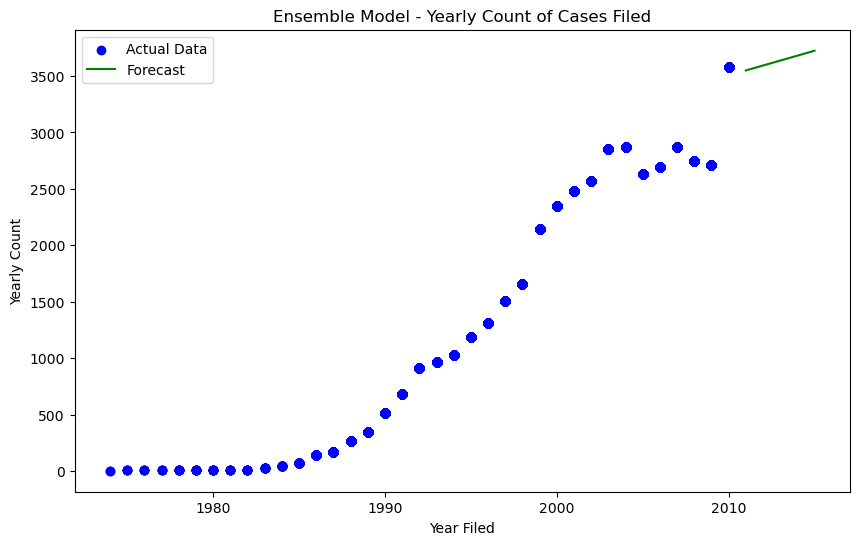

In [71]:
#-- Plotting the original data, predictions, and forecast --#
plt.figure(figsize=(10, 6))

#-- Plotting the actual yearly counts --#
plt.scatter(X, y, color='blue', label='Actual Data')

#-- Plotting the predictions on the test set --#


#-- Plotting the forecast for the next 5 years --#
plt.plot(future_years, future_predictions, color='green', label='Forecast')

plt.title('Ensemble Model - Yearly Count of Cases Filed')
plt.xlabel('Year Filed')
plt.ylabel('Yearly Count')
plt.legend()
plt.show()
